# Getting started with Bayesflow

Throughout this collection of examples, we will use the `BayesFlow`
software to work our way through the examples. `BayesFlow` is a package
implemented in Python, and at this moment of time, Python is the only
reasonable choice to use `BayesFlow`. We encourage you to familiarize
yourself with Python before delving deeper into these examples.

In this chapter, we start by working through a concrete example using
`BayesFlow`. This provides an introduction to the `BayesFlow` interface,
and the basic theoretical and practical components involved in amortized
Bayesian model analysis.

## Setting up your computing environment

We encourage you to follow good software practices regarding keeping
your workspace tidy and reproducible. We will use `conda` for managing
the environment, respectively. Feel free to use whatever you feel the
most comfortable.

## Installing BayesFlow

Follow installation instructions on the BayesFlow website:
<https://bayesflow.org/main/index.html#install>. After initiating and
activating the python environment, we can simply install BayesFlow using
`pip`

``` bash
conda create --name cognitive-modeling-book python=3.11.11
conda activate cognitive-modeling-book
pip install bayesflow
```

`BayesFlow` uses the `keras` library, which in turn uses `TensorFlow`,
`PyTorch`, or `JAX` as a backend. You have to install at least one of
the three backends of your choice in your environment. We recommend
using `JAX`.

``` bash
pip install jax
```

To make sure that `keras` can access the backend, you will need to
specify the `KERAS_BACKEND` enviroment variable in every Python session.

``` python
import os
os.environ["KERAS_BACKEND"] = "jax"
```

Alternatively, you can use conda to set the environment variable
permanently.

``` bash
conda env config vars set KERAS_BACKEND=jax
```

(Assuming your terminal has the correct `conda` environment activated)

## Using `BayesFlow`

After installation, `BayesFlow` and its subcomponents can be loaded in
Python as any other Python library.

Here we will generate a very simple beta-binomial model that can be
written as

The target of inference it the binomial proportion $\theta$, given the
uniform prior $\text{Beta}(1, 1)$, the observed $k$ successes out of
$n=10$ trials.

First, we will load the necessary packages.

In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

INFO:bayesflow:Using backend 'jax'

### Simulator

We need to define the simulator that samples from the joint prior
distribution of the parameters and data, $p(\theta, k$.

To do that, we first define the simulator function of the prior, and the
simulator function of the likelihood (that generates data conditionally
on the values of the parameters). Then, we combine them together into
one simulator object.

In [2]:
def prior():
    return dict(theta = np.random.beta(a=1, b=1))

def likelihood(theta):
    return dict(k=np.random.binomial(n=10, p=theta))

simulator = bf.simulators.make_simulator([prior, likelihood])

Sampling from the simulator is done using the `.sample` method. The
output of the simulator is a dictionary with all generated variables
(`theta`, `k`) as keys.

In [3]:
simulator.sample(5)

{'theta': array([[0.9943611 ],
        [0.03731827],
        [0.07959112],
        [0.28499102],
        [0.91830714]]),
 'k': array([[10],
        [ 0],
        [ 2],
        [ 5],
        [ 9]])}

Here, we generated data from the model five times, drawing five
different values of $\theta$ and using those to obtain five different
values of the number of successes, $k$. Both values are returned in the
output dictionary. In essence, we have obtained 5 independent draws from
the prior predictive distribution.

### Approximator

Now that we have defined the generative model, we can build our
approximator. Its goal is to produce the posterior distribution of the
parameter $\theta$, given some number of successes $k$.

For approximating the posterior distribution of continuous parameters,
we can instantiate an object of class
`bf.approximators.ContinuousApproximator`. However, we can also define a
workflow object, `bf.BasicWorkflow`, which stores some additional
information (e.g., the simulator) to allow easier inference and
diagnostics. We will use that class now.

A continuous approximator (and by extension, workflow), contains an
inference network, and (optionally) a summary network. To pass the
output from the simulator into the networks, we use a `bf.Adapter` to
transform the simulator outputs into dictionary with keys that the
approximator knows how to deal with. A continuous approximator accepts
the following keys:

-   `"inference_variables"`: Variables for which to do the posterior
    approximation (i.e., parameters) using an inference network.
-   `"inference_conditions"`: Variables that are directly passed as
    conditions to the inference network.
-   `"summary_variables"`: Variables that are passed into a summary
    network (optional). The output of the summary network is then passed
    together with `"inference_conditions"` into the inference network.

The adapter can additionally handle some reshaping and transformations
of our inputs. Here for example, we indicate that the parameter $\theta$
is constrained between 0 and 1 to ensure that the parameter boundaries
are respected during inference.

In [4]:
adapter = (
    bf.Adapter()
    .constrain("theta", lower=0, upper=1)
    .rename("theta", "inference_variables")
    .rename("k", "inference_conditions")
    )

In [5]:
worfklow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

Once we defined our approximator, we can train it using simulated data.

In [ ]:
history = worfklow.fit_online(epochs=30)

### Validation

After training, we can validate our networks. The `BasicWorkflow` object
we defined provides some basic diagnostics, which often comes in handy
to conduct quick, boilerplate validation.

The basic idea of diagnostics are as follows: We first generate a batch
of fresh test data from the simulator. Then, we apply our networks on
these simulations, obtaining a posterior approximation for each
simulated data set.

Then, we can use the simulations and predicted posteriors for model
checks, such as parameter recovery, simulation-based calibration, model
sensitivity, and so on. To read about these diagnostics in more depth,
please refer to Schad et al. (2021) and Talts et al. (2018). Most of
these diagnostics are possible to obtain with traditional (MCMC) methods
as well (e.g. Kucharský et al., 2021), though it is typically very
laborious to run them. ABI makes these checks very easy because
inference at this stage is cheap.

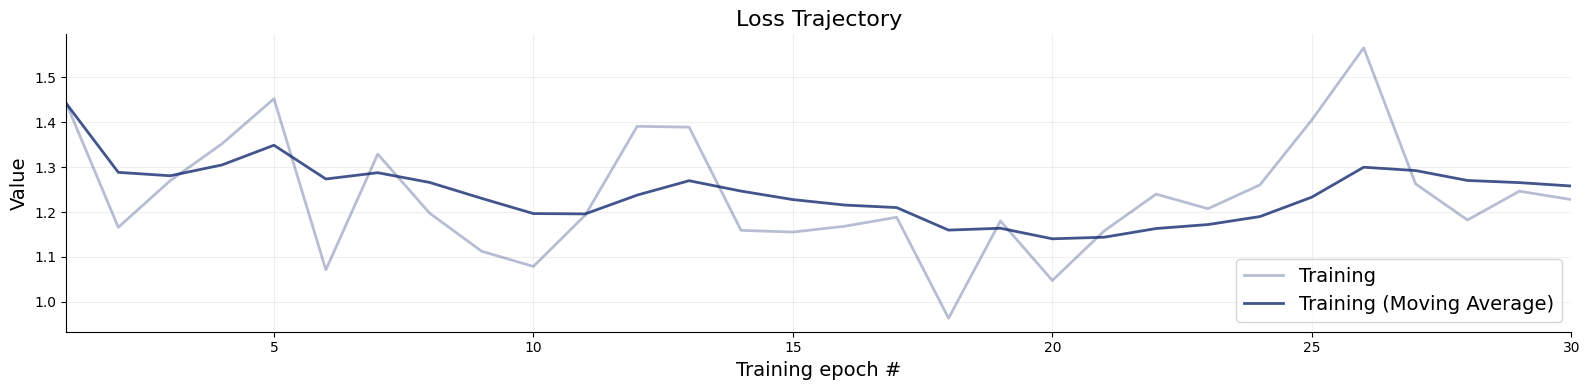

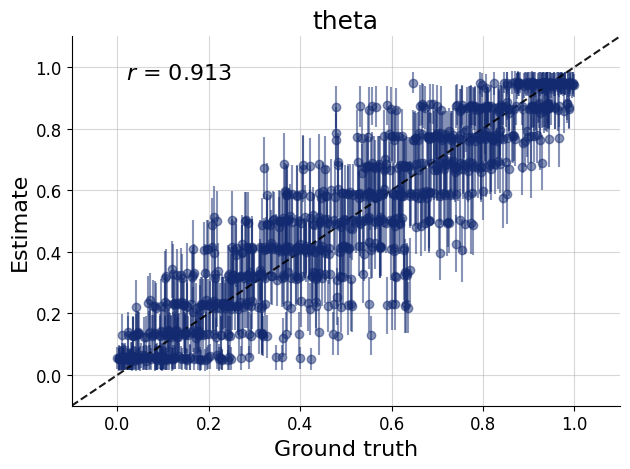

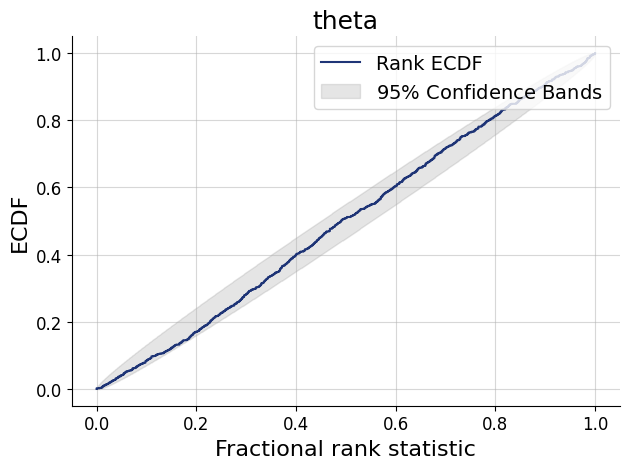

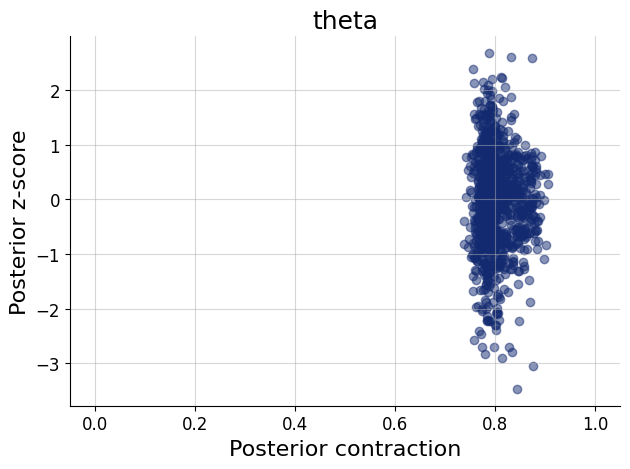

In [7]:
test_data = simulator.sample(1000)
figs=worfklow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

After training and validation, we use our approximator to infer the
posterior distribution of $\theta$ given observed data. Here we compute
the posterior if observed 7 successes.

The `data` needs to be specified in the same format as produced by the
simulator (except that now we will be missing the keys of the variables
we are inferring, i.e., `"theta"`).

In [8]:
inference_data = dict(k = np.array([[7]]))

In [9]:
samples = worfklow.sample(conditions=inference_data, num_samples=1000)

Now we can for example plot the posterior approximation of the
parameter.

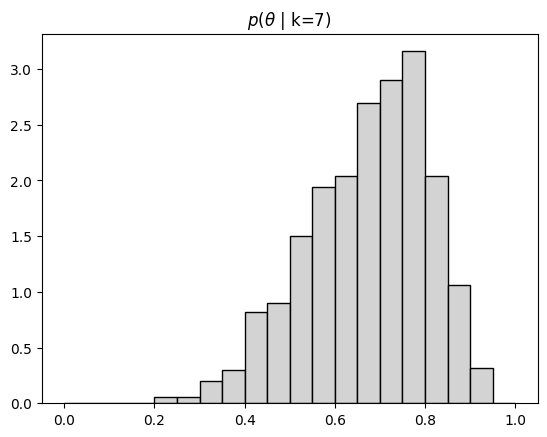

In [16]:
f = plt.hist(samples["theta"].flatten(),
             density=True, color="lightgray", edgecolor="black", bins=np.arange(0, 1.05, 0.05))
title = plt.title(r"$p(\theta$ | k=7)")

## Conclusion

If you managed to go through the steps above, congratulations! You have
created and ran a Bayesian model using `BayesFlow`.

The example presented in this document is rather simple and would not be
that useful in analysis of real data, as we trained a very specific
model (a binomial model with fixed number of trials $n=10$ and fixed
hyperparameters of the prior distribution
$\theta \sim \text{Beta}(1, 1)$). Since the model is so simple, we also
did not use any summary network.

However, successuly running this example should give you confidence that
at least `BayesFlow` *works on your computer*. You are ready to go to
the next examples.

Kucharský, Š., Tran, N.-H., Veldkamp, K., Raijmakers, M., & Visser, I.
(2021). Hidden markov models of evidence accumulation in speeded
decision tasks. *Computational Brain & Behavior*, *4*, 416–441.

Schad, D. J., Betancourt, M., & Vasishth, S. (2021). Toward a principled
Bayesian workflow in cognitive science. *Psychological Methods*,
*26*(1), 103.

Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A.
(2018). Validating bayesian inference algorithms with simulation-based
calibration. *arXiv Preprint arXiv:1804.06788*.